Let's define the functions to generate stochastic trajectories

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

import sdeint
from scipy.integrate import solve_ivp

from tqdm import tqdm
from tqdm.notebook import tqdm

np.random.seed(42)

In [2]:
def realization_with_params_time_initial_conditions(l, o, a, b, sigma, X0, tfin, tstep):
    tspan = np.linspace(0.0, tfin, int(tfin/tstep + 1))

    params_F = [l, o, a, b]

    params_G = [np.diag([sigma, 0.0])]

    return sdeint.itoint(close(F,*params_F) , close(G, *params_G), X0, tspan)

def F(X, t, l, o, a, b):
    
    x = X[0]
    y = X[1]
    
    r2 = x**2 + y**2
    
    dx = x*(l - b*r2) - y*(o + a*r2)
    dy = x*(o + a*r2) + y*(l - b*r2)
    
    return np.array([dx, dy])

def G(X, t, B):
    return B

def close(func, *args):
    def newfunc(x, t):
        return func(x, t, *args)
    return newfunc

def create_initial_condition():
    theta = np.random.uniform(low = 0.0, high = 2*np.pi)
    x0 = np.cos(theta)
    #y0 = np.random.choice([-np.sqrt(1 - x0**2), np.sqrt(1 - x0**2)])
    y0 = np.sin(theta)
    return np.array([x0, y0])

Let's create 1000 initial points on the unit circle to evaluate the effect of different initial conditions

In [3]:
ini_points = np.empty((1000,2))
for i in range(1000):
    ini_points[i] = create_initial_condition()

Now, we will create 1000 trajetories (one per each initial point), all of them with the same parameters (lambda = 1, omega = 1, a = 1, b = 1, sigma = 0.1) and we will integrate the trajectory for 30 seconds. Then we will try to align, and average the ensemble.

In [16]:
l = 1
o = 1
a = 1
b = 1
sigma = 0.1
tfin = 30
tstep = 0.01
rs = []
for i in tqdm(range(1000)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [245]:
from scipy.signal import find_peaks

def move_to_origin_and_crop(r, origin, max_points):
    #traslate and cut the trajectory to coincide with origin (i.e x0 = 1.0, y0 = 0.0)
    val = find_peaks(-np.sum((origin - r)**2, axis = 1), height=-0.1)[0][0]
    return r[val:max_points+val,:]

In [257]:
rs_0 = []
origin = np.array([1.0, 0.0])
for i in range(1000):
    rs_0.append(move_to_origin_and_crop(rs[i],origin, 2500))

In [554]:
def mean_traj(rs):
    n_traj = len(rs)
    len_traj = len(rs[0])
    X = np.empty((n_traj, len_traj))
    Y = np.empty((n_traj, len_traj))
    for i in range(n_traj):
        X[i,:] = rs[i][:,0]
        Y[i,:] = rs[i][:,1]
    return np.mean(X, axis = 0)**2 + np.mean(Y, axis = 0)**2
    #R = X**2 + Y**2
    #return np.mean(R, axis = 0)

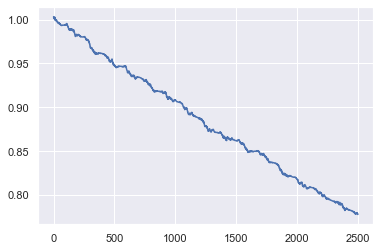

In [276]:
plt.plot(mean_traj(rs_0))

In [350]:
l = 0.5
o = 1
a = 1
b = 0.5
sigma = 0.1
tfin = 50
tstep = 0.01
rs = []
for i in tqdm(range(1000)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [351]:
rs_05_01 = []
origin = np.array([1.0, 0.0])
for i in range(1000):
    rs_05_01.append(move_to_origin_and_crop(rs[i],origin, 4500))

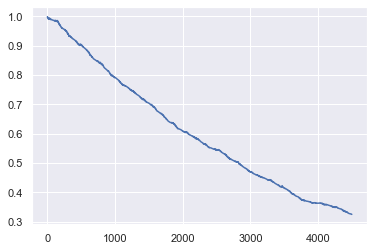

In [352]:
plt.plot(mean_traj(rs_05_01))

In [284]:
l = 0.1
o = 1
a = 1
b = 0.1
sigma = 0.1
tfin = 30
tstep = 0.01
rs = []
for i in tqdm(range(1000)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [285]:
rs_01_01 = []
origin = np.array([1.0, 0.0])
for i in range(1000):
    rs_01_01.append(move_to_origin_and_crop(rs[i],origin, 2500))

In [383]:
l = 5
o = 1
a = 1
b = 5
sigma = 0.1
tfin = 100
tstep = 0.01
rs = []
for i in tqdm(range(1000)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [384]:
rs_5_01 = []
origin = np.array([1.0, 0.0])
for i in range(1000):
    rs_5_01.append(move_to_origin_and_crop(rs[i],origin, 9500))

In [375]:
l = 2
o = 1
a = 1
b = 2
sigma = 0.1
tfin = 100
tstep = 0.01
rs = []
for i in tqdm(range(1000)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [376]:
rs_2_01 = []
origin = np.array([1.0, 0.0])
for i in range(500):
    rs_2_01.append(move_to_origin_and_crop(rs[i],origin, 9500))

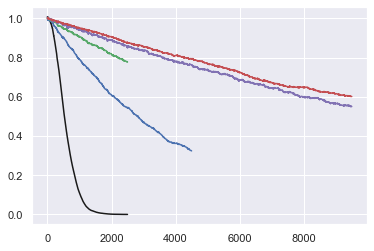

In [385]:
#ts = tspan[:2500]
plt.plot(mean_traj(rs_01_01),'k')
plt.plot(mean_traj(rs_05_01),'b')
plt.plot(mean_traj(rs_0),'g')
plt.plot(mean_traj(rs_2_01),'m')
plt.plot(mean_traj(rs_5_01),'r')

In [470]:
from scipy.optimize import fsolve, curve_fit

def sigmoid(x, x0, k):
    """
    Sigmoid function between 0 and 1, variable slope k and x0 midpoint position
    """
    return 1 / (1 + np.exp(-k*(x-x0)))

def sigmoid2(x, x0, k, h):
    """
    Sigmoid function between 0 and h, variable slope k and x0 midpoint position
    """
    return h / (1 + np.exp(-k*(x-x0)))

def sigmoid3(x, x0, k1, k2):
    """
    double sig
    """
    return np.exp(-k1*(x-x0)) / (1 + np.exp(-k2*(x-x0)))


def monoexp(x, x0, k):
    return np.exp(-k*(x-x0))

def biexp(x, A, k1, k2):
    return A*np.exp(-k1*x) + (1.0 - A)*np.exp(-k2*x)

def linear(x, A, B):
    return A*x + B

# Non-linear curve fitting using sigmoid function
def fit_r(func, x_data, y_data):
    
    if func == sigmoid:
        p0 = [np.median(x_data),1] # this is an mandatory initial guess
    elif func == sigmoid2:
        p0 = [np.median(x_data),1, np.max(y_data)] # this is an mandatory initial guess
    elif func == sigmoid3:
        p0 = [np.median(x_data),1e-2, 1e-2] # this is an mandatory initial guess
    elif func == monoexp:
        p0 = [-1, 0] # this is an mandatory initial guess
    elif func == biexp:
        p0 = [0.1, 0.1, 0.1] # this is an mandatory initial guess
    elif func == linear:
        p0 = [1,1]

        
    popt, _ = curve_fit(func, x_data, y_data, p0)
    
    return popt

[1.23049306e+02 8.72228663e-03 5.27144981e-03]


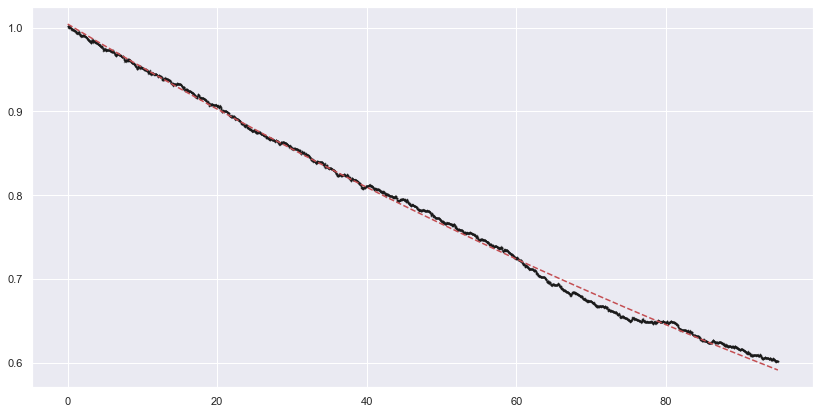

In [386]:
traj = rs_5_01
ts = np.arange(len(mean_traj(traj)))*0.01
popt = fit_r(sigmoid3, ts, mean_traj(traj))
print(popt)

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(ts, mean_traj(traj), 'k.', alpha = 0.5, markersize = 1)
plt.plot(ts, sigmoid3(ts, *popt), 'r', linestyle = '--');

In [422]:
lams = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
x0s = [5.43, 7.94, 27.98, 68.07, 108.22, 123.05, 138.86]
k1s = [0.471, 0.047, 1.82e-2, 8.479e-3, 9.79e-3, 8.72e-3, 6.65e-3]
k2s = [0.448, -0.13, -1.586e-2, -3.673e-3, 5.866e-3, 5.27e-3, 3.07e-3]

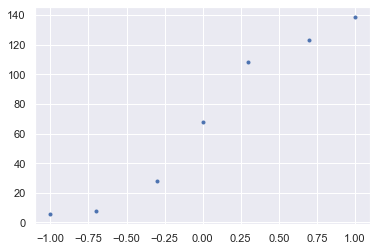

In [427]:
plt.plot(np.log10(lams), x0s,'.')

In [391]:
l = 0.2
o = 1
a = 1
b = 0.2
sigma = 0.1
tfin = 100
tstep = 0.01
rs = []
for i in tqdm(range(100)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [394]:
rs_02_01 = []
origin = np.array([1.0, 0.0])
for i in range(100):
    rs_02_01.append(move_to_origin_and_crop(rs[i],origin, 9500))

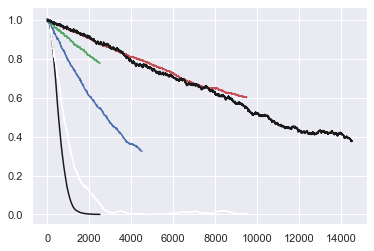

In [418]:
plt.plot(mean_traj(rs_01_01),'k')
plt.plot(mean_traj(rs_02_01),'w')
plt.plot(mean_traj(rs_05_01),'b')
plt.plot(mean_traj(rs_0),'g')
#plt.plot(mean_traj(rs_2_01),'m')
plt.plot(mean_traj(rs_5_01),'r')
plt.plot(mean_traj(rs_10_01),'k')

[ 7.93528498  0.04756572 -0.13047395]


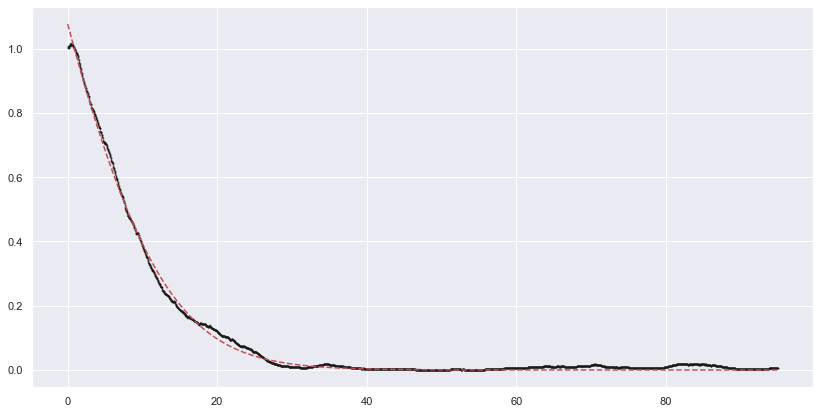

In [399]:
traj = rs_02_01
ts = np.arange(len(mean_traj(traj)))*0.01
popt = fit_r(sigmoid3, ts, mean_traj(traj))
print(popt)

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(ts, mean_traj(traj), 'k.', alpha = 0.5, markersize = 1)
plt.plot(ts, sigmoid3(ts, *popt), 'r', linestyle = '--');

In [419]:
l = 10
o = 1
a = 1
b = 10
sigma = 0.1
tfin = 150
tstep = 0.01
rs = []
for i in tqdm(range(1000)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [420]:
rs_10_01 = []
origin = np.array([1.0, 0.0])
for i in range(1000):
    rs_10_01.append(move_to_origin_and_crop(rs[i],origin, 14500))

[1.38860905e+02 6.65113196e-03 3.07387406e-03]


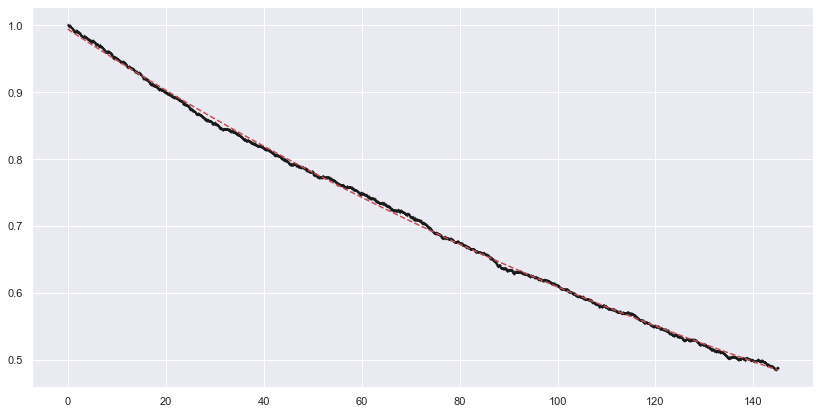

In [421]:
traj = rs_10_01
ts = np.arange(len(mean_traj(traj)))*0.01
popt = fit_r(sigmoid3, ts, mean_traj(traj))
print(popt)

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(ts, mean_traj(traj), 'k.', alpha = 0.5, markersize = 1)
plt.plot(ts, sigmoid3(ts, *popt), 'r', linestyle = '--');

It seem's that 1000 trajectories are enough to obtain a decent mean trajectory if the simulations are done during enough time. Let's see the effect of running half the time, but doubling the simulations

In [428]:
l = 10
o = 1
a = 1
b = 10
sigma = 0.1
tfin = 75
tstep = 0.01
rs = []
for i in tqdm(range(2000)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [429]:
rs_10_01b = []
origin = np.array([1.0, 0.0])
for i in range(2000):
    rs_10_01b.append(move_to_origin_and_crop(rs[i],origin, 7000))

[1.26405116e+02 9.75833433e-03 7.04901196e-03]


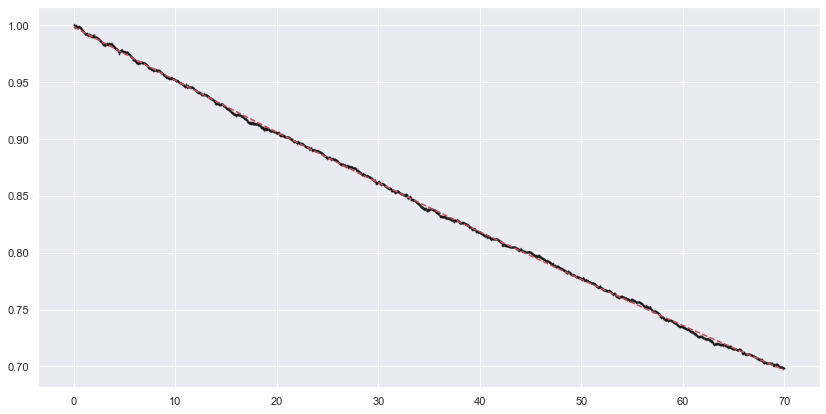

In [430]:
traj = rs_10_01b
ts = np.arange(len(mean_traj(traj)))*0.01
popt = fit_r(sigmoid3, ts, mean_traj(traj))
print(popt)

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(ts, mean_traj(traj), 'k.', alpha = 0.5, markersize = 1)
plt.plot(ts, sigmoid3(ts, *popt), 'r', linestyle = '--');

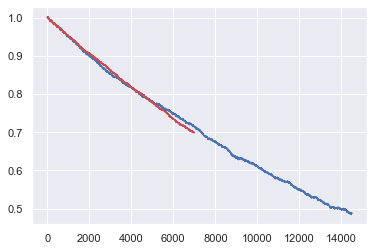

In [432]:
plt.plot(mean_traj(rs_10_01),'b')
plt.plot(mean_traj(rs_10_01b),'r')
plt.show()

To have a good approximation to the half life times, ussually at least 3 have to been recorded. Let's explore this for the shortest lambda 0.1 simulation

In [433]:
l = 0.1
o = 1
a = 1
b = 0.1
sigma = 0.1
tfin = 18
tstep = 0.01
rs = []
for i in tqdm(range(100)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [446]:
rs_01_01b = []
origin = np.array([1.0, 0.0])
for i in range(100):
    rs_01_01b.append(move_to_origin_and_crop(rs[i],origin, 1400))

[ 5.16853576  0.01851351 -0.5214025 ]


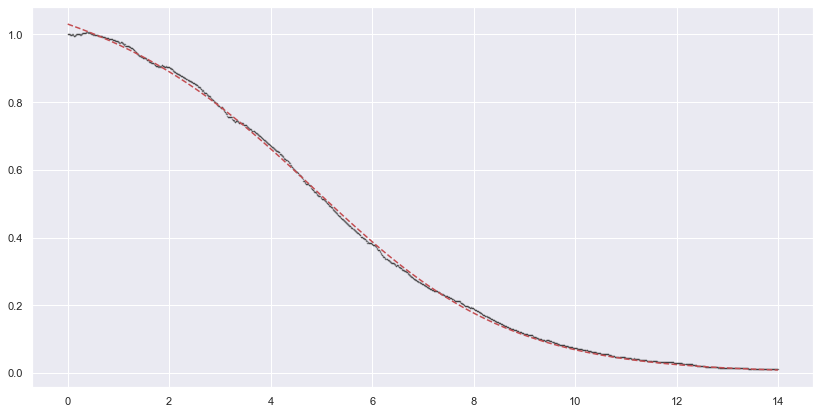

In [465]:
traj = rs_01_01b
ts = np.arange(len(mean_traj(traj)))*0.01
popt = fit_r(sigmoid3, ts, mean_traj(traj))
print(popt)

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(ts, mean_traj(traj), 'k.', alpha = 0.5, markersize = 1)
plt.plot(ts, sigmoid3(ts, *popt), 'r', linestyle = '--');

In [475]:
l = 0.2
o = 1
a = 1
b = 0.2
sigma = 0.1
tfin = 30
tstep = 0.01
rs = []
for i in tqdm(range(1000)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [476]:
rs_02_01b = []
origin = np.array([1.0, 0.0])
for i in range(1000):
    rs_02_01b.append(move_to_origin_and_crop(rs[i],origin, 2600))

[ 8.70992001  0.04011975 -0.12945885]


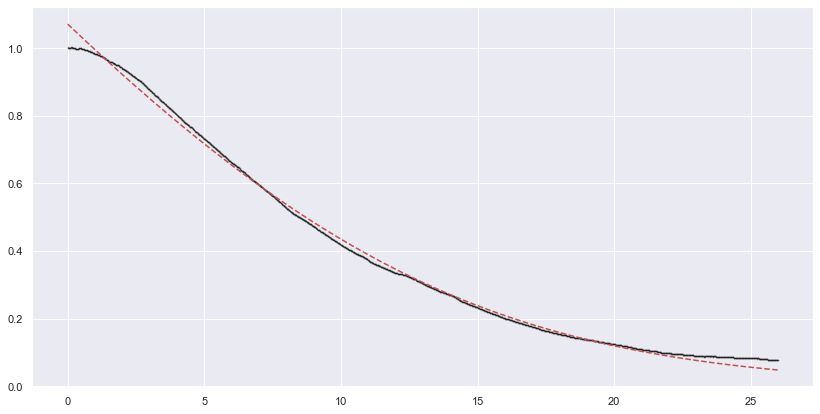

In [477]:
traj = rs_02_01b
ts = np.arange(len(mean_traj(traj)))*0.01
popt = fit_r(sigmoid3, ts, mean_traj(traj))
print(popt)

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(ts, mean_traj(traj), 'k.', alpha = 0.5, markersize = 1)
plt.plot(ts, sigmoid3(ts, *popt), 'r', linestyle = '--');

In [479]:
l = 0.5
o = 1
a = 1
b = 0.5
sigma = 0.1
tfin = 50
tstep = 0.01
rs = []
for i in tqdm(range(1000)):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[i,:], tfin, tstep))

In [480]:
rs_05_01b = []
origin = np.array([1.0, 0.0])
for i in range(1000):
    rs_05_01b.append(move_to_origin_and_crop(rs[i],origin, 4500))

[ 2.94777910e+01  1.05312664e-02 -3.43513343e-02]


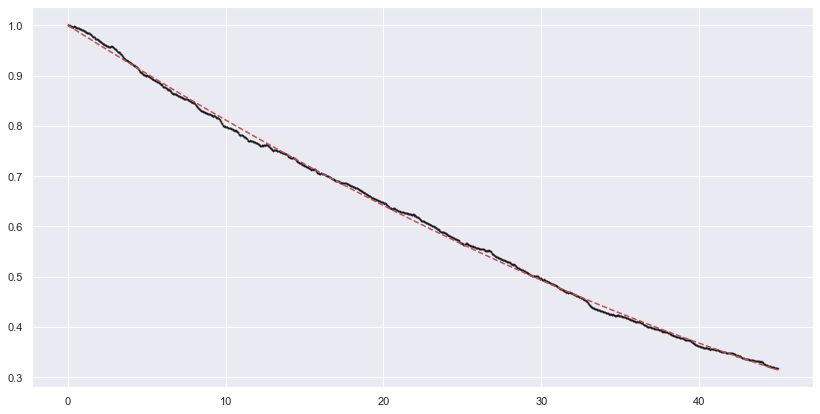

In [481]:
traj = rs_05_01b
ts = np.arange(len(mean_traj(traj)))*0.01
popt = fit_r(sigmoid3, ts, mean_traj(traj))
print(popt)

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(ts, mean_traj(traj), 'k.', alpha = 0.5, markersize = 1)
plt.plot(ts, sigmoid3(ts, *popt), 'r', linestyle = '--');

Let's build a set of simulations ranging from 0.1 to 10 by performing 1000 trajectories of the 2 estimated half life for each value

In [482]:
lambdas = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
estimated_2half = [12, 20, 60, 140, 220, 250, 300]

In [484]:
trajs = {}


o = 1
a = 1
sigma = 0.1
tstep = 0.01
n_sims = 1000
for i in range(len(lambdas)):
    l = lambdas[i]
    b = lambdas[i]
    tfin = estimated_2half[i]
    
    #create initial points
    ini_points = np.empty((n_sims,2))
    for i in range(n_sims):
        ini_points[i] = create_initial_condition()
    
    #initializes list for simulations
    rs = []
    for j in tqdm(range(n_sims)):
        rs.append(realization_with_params_time_initial_conditions(l, o, a, b, sigma, ini_points[j,:], tfin, tstep))

    trajs[l] = rs

In [499]:
trajs_o = {}
origin = np.array([1.0, 0.0])
for t in range(len(lambdas)):
    temp = []
    min_points = 100*estimated_2half[t]
    for i in range(1000):
        min_points = min(min_points, len(move_to_origin_and_crop(trajs[lambdas[t]][i], origin, min_points)))
    
    for i in range(1000):
        temp.append(move_to_origin_and_crop(trajs[lambdas[t]][i], origin, min_points))
    
    trajs_o[lambdas[t]] = temp

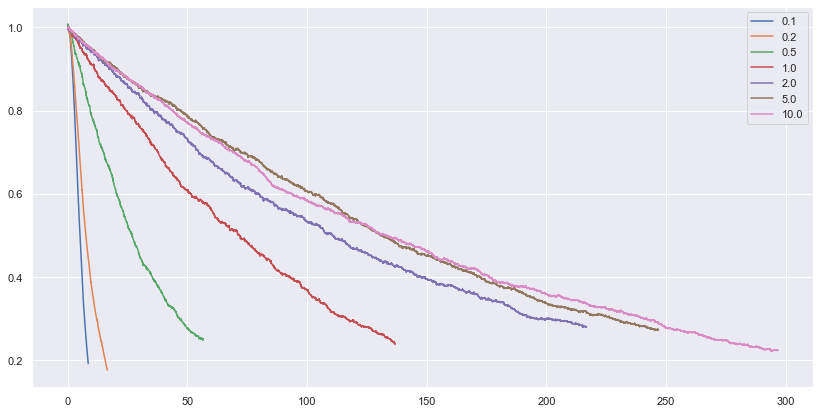

In [555]:
fig, ax = plt.subplots(figsize=(14,7))
for i in trajs_o.keys():
    traj = mean_traj(trajs_o[i])
    ts = np.arange(len(traj))*0.01
    plt.plot(ts, traj, label = str(i))
plt.legend()
plt.show()

In [518]:
fit_x12 = []
fit_k1 = []
fit_k2 = []
for i in trajs_o.keys():
    traj = mean_traj(trajs_o[i])
    ts = np.arange(len(traj))*0.01
    
    popt = fit_r(sigmoid3, ts, traj)
    fit_x12.append(popt[0])
    fit_k1.append(popt[1])
    fit_k2.append(popt[2])

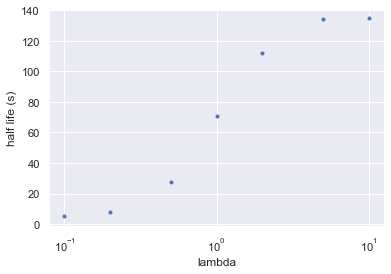

In [536]:
plt.plot(lambdas, fit_x12,'.')
plt.xlabel('lambda')
plt.ylabel('half life (s)')
plt.xscale('log')
plt.show()

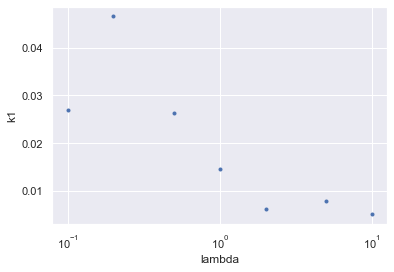

In [531]:
plt.plot(lambdas, fit_k1,'.')
plt.xlabel('lambda')
plt.ylabel('k1')
plt.xscale('log')
plt.show()

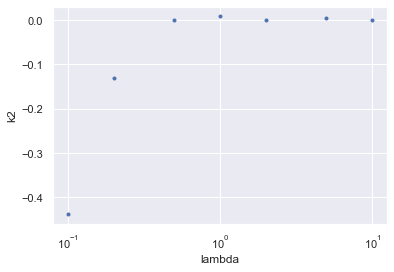

In [532]:
plt.plot(lambdas, fit_k2,'.')
plt.xlabel('lambda')
plt.ylabel('k2')
plt.xscale('log')
plt.show()

In [544]:
def std_traj(rs):
    n_traj = len(rs)
    len_traj = len(rs[0])
    X = np.empty((n_traj, len_traj))
    Y = np.empty((n_traj, len_traj))
    for i in range(n_traj):
        X[i,:] = rs[i][:,0]
        Y[i,:] = rs[i][:,1]
    return np.std(X**2 + Y**2, axis = 0)

In [556]:
fit_x0 = []
fit_k = []
for i in trajs_o.keys():
    traj = mean_traj(trajs_o[i])
    ts = np.arange(len(traj))*0.01
    
    popt = fit_r(monoexp, ts, traj)
    fit_x0.append(popt[0])
    fit_k.append(popt[1])

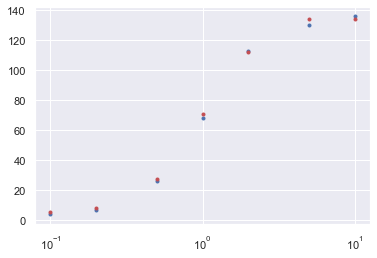

In [575]:
plt.plot(lambdas, np.log(2)/fit_k, 'b.')
plt.plot(lambdas, fit_x12, 'r.')
plt.xscale('log')
plt.show()

In [576]:
np.log(2)/fit_k

array([  4.08810645,   6.59004846,  26.3443006 ,  68.14737819,
       113.18623614, 130.03745706, 135.99673894])

In [581]:
import bz2
import pickle
import _pickle as cPickle

In [582]:
with bz2.BZ2File('trajectories_multiple_initial_conditions.pbz2', 'w') as f: 
    cPickle.dump(trajs_o, f)

In [580]:
pickle.dump?